<a href="https://colab.research.google.com/github/lblum95/AML/blob/master/task3/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/AML
!git branch
%cd /content/drive/My Drive/Colab Notebooks/AML/task3

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/AML
  master
* yb-t2
/content/drive/My Drive/Colab Notebooks/AML/task3


In [51]:
!pip install neurokit2
!pip install biosppy
!pip install pip install pycwt

     |████████████████████████████████| 768kB 5.6MB/s 
  Created wheel for pycwt: filename=pycwt-0.3.0a22-cp36-none-any.whl size=17808 sha256=859eb9f399bd50177cf225f149a9ce1e17cb10b5f992ba49d308c248eb81edfb
  Stored in directory: /root/.cache/pip/wheels/e2/e0/b4/311806bd9b792ec6904dbac270666e88912a345730711283af
Successfully built pycwt


In [176]:
import warnings
warnings.filterwarnings('ignore')

import neurokit2 as nk
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from biosppy.signals import ecg
from tqdm import tqdm  
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, Masking, GRU, Bidirectional
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pp
import pycwt as wavelet
import seaborn as sb
from scipy.interpolate import interp1d

In [459]:
X_learn=pd.read_csv('data/X_train.csv',index_col='id')
Y_learn=pd.read_csv('data/y_train.csv',index_col='id')


#X_shitty=X_learn.iloc[np.where(Y_learn==3)[0],:]
# X_learn['Y']=Y_learn
# X_learn['idx']=X_learn.index
# X_learn.set_index(["idx","i"],inplace=True)
# X_learn.sort_index(axis=0,inplace=True)

# X_sick=X_learn.loc[X_learn.index.get_level_values("Y")==1]


frequency= 300

In [460]:
X_learn

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,...,x17939,x17940,x17941,x17942,x17943,x17944,x17945,x17946,x17947,x17948,x17949,x17950,x17951,x17952,x17953,x17954,x17955,x17956,x17957,x17958,x17959,x17960,x17961,x17962,x17963,x17964,x17965,x17966,x17967,x17968,x17969,x17970,x17971,x17972,x17973,x17974,x17975,x17976,x17977,x17978
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-863,-860,-857,-854,-851,-849,-846,-843,-838,-831,-821,-807,-785,-771,-753,-731,-709,-685,-663,-647,-633,-621,-612,-600,-586,-576,-567,-560,-553,-547,-542,-537,-531,-525,-517,-509,-500,-490,-475,-455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-137,-132,-123,-107,-79,-59,-45,-47,-70,-107,-139,-152,-160,-164,-160,-148,-131,-107,-68,-19,-4,-1,0,1,2,2,2,2,3,4,6,7,7,8,10,12,14,16,18,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-727,-736,-748,-784,-831,-874,-917,-967,-1029,-1112,-1205,-1297,-1379,-1432,-1457,-1471,-1482,-1482,-1470,-1440,-1387,-1325,-1266,-1221,-1196,-1171,-1143,-1112,-1082,-1055,-1025,-989,-954,-919,-888,-860,-833,-804,-776,-730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-103,-98,-92,-87,-81,-77,-71,-65,-61,-59,-59,-63,-69,-75,-81,-87,-94,-101,-109,-118,-126,-131,-134,-137,-140,-141,-143,-144,-146,-147,-148,-150,-152,-153,-154,-155,-156,-157,-158,-159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,2,-1,-3,-5,-7,-10,-12,-14,-14,-13,-9,-3,3,10,18,28,38,46,53,57,60,64,68,70,71,70,69,68,67,66,65,63,62,61,60,61,62,63,65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,-88,-158,-237,-316,-384,-437,-487,-505,-504,-485,-434,-375,-317,-260,-228,-194,-170,-158,-151,-142,-133,-121,-101,-69,-34,2,23,32,38,42,45,49,52,54,56,58,61,64,68,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5113,7,4,1,0,-3,-7,-12,-22,-36,-38,-39,-40,-41,-42,-40,-32,-23,-13,-1,5,6,8,8,8,8,9,9,11,15,20,24,29,36,43,51,58,63,68,72,77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,-1464,-1454,-1445,-1437,-1431,-1422,-1390,-1327,-1256,-1190,-1138,-1090,-1044,-1017,-968,-908,-888,-899,-932,-989,-1022,-1056,-1085,-1101,-1113,-1117,-1112,-1098,-1057,-1000,-964,-951,-951,-964,-983,-1010,-1039,-1061,-1074,-1084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
meanwaves=[]
varwaves=[]
nbofdiscards=[]
hrvs=[]

# j=116
# if j==116:
for j in tqdm(range(5117)):
  n=17979-X_learn.iloc[j,:].isna().sum()
  patient=X_learn.iloc[j,800:n]

  # n=17979-X_learn.iloc[j,:].isna().sum()
  # patient=X_learn.iloc[j,800:n]

  #print("Signal nb", j)
  pwaves=[]
  patient = nk.ecg_clean(patient, sampling_rate=300)

  out = ecg.ecg(signal=patient, sampling_rate=300, show=False)
  max=abs(np.mean(np.max(out['templates'],axis=1)))
  min=abs(np.mean(np.min(out['templates'],axis=1)))

  if max<min:
    #print("invert",i)
    patient=-patient
    out = ecg.ecg(signal=patient, sampling_rate=300, show=False)
    max=min

  #fig, ax = plt.subplots()
  #plt.plot(patient)


  ######## we extract the region between two r peaks, from right to left we extract 90% of the distance
  rpeaks=out['rpeaks']
  nbOfpeeks=rpeaks.shape[0]-1
  for i in range(nbOfpeeks):

    diff=rpeaks[i+1]-rpeaks[i]
    if diff<100:
      continue
    start=int(rpeaks[i+1]-(diff*0.9))
    end=rpeaks[i+1]-20
    #ax.axvspan(start,end, alpha=0.1, color='r')
    pwave=patient[start:end]
    ###### we check if the signal has an engery higher than 200 if yes we discard it, else we resample the signal to a size of 100 and add it to the other pwaves
    energy=np.sum(abs(pwave))/np.shape(pwave)[0]
    nbofdiscard=0
    if energy<200:
      pwave=resampling(pwave,100)
      pwaves.append(pwave)
    else:
      nbofdiscard+=1
      #print("wave nb", i,"discarded because E=", energy)
  
  if len(pwaves)==0:
    pwave=resampling(pwave,100)
    pwaves.append(pwave)

  meanwave=np.mean(pwaves,axis=0)
  meanwave=meanwave/np.std(meanwave)
  meanwaves.append(meanwave)

  warwave=np.var(pwaves,axis=0)
  varwaves.append(warwave)

  nbofdiscards.append(nbofdiscard/nbOfpeeks)


  
  rpeaks_diff=rpeaks-(np.insert(rpeaks,0,0)[:-1])
  rpeaks_diff=rpeaks_diff-np.median(rpeaks_diff)
  hrv=sum(rpeaks_diff>40)/np.shape(rpeaks_diff)[0]
  hrvs.append(hrv)
  
  # print("hrv metric", hrv)
  # plt.show()
  # plt.plot(meanwave)
  # plt.show()
  # plt.plot(np.var(pwaves,axis=0))
  # plt.show()





meanwaves2=np.array(meanwaves)
varwaves2=np.array(varwaves)
hrvs2=np.expand_dims(np.array(hrvs),1)
nbofdiscards2=np.expand_dims(np.array(nbofdiscards),1)
data=np.hstack((meanwaves2,varwaves2,hrvs2,nbofdiscards2))
df=pd.DataFrame(data=data)
df.to_csv('data/YBfeatures.csv',index_label="id")


Streaming output truncated to the last 5000 lines.

 86%|████████▌ | 4402/5117 [1:07:44<12:24,  1.04s/it]






 86%|████████▌ | 4403/5117 [1:07:45<11:15,  1.06it/s]






 86%|████████▌ | 4404/5117 [1:07:46<10:31,  1.13it/s]






 86%|████████▌ | 4405/5117 [1:07:47<09:56,  1.19it/s]






 86%|████████▌ | 4406/5117 [1:07:47<09:27,  1.25it/s]






 86%|████████▌ | 4407/5117 [1:07:48<09:14,  1.28it/s]






 86%|████████▌ | 4408/5117 [1:07:49<11:06,  1.06it/s]






 86%|████████▌ | 4409/5117 [1:07:51<12:49,  1.09s/it]






 86%|████████▌ | 4410/5117 [1:07:52<13:57,  1.18s/it]






 86%|████████▌ | 4411/5117 [1:07:54<14:42,  1.25s/it]






 86%|████████▌ | 4412/5117 [1:07:54<12:57,  1.10s/it]






 86%|████████▌ | 4413/5117 [1:07:56<13:44,  1.17s/it]






 86%|████████▋ | 4414/5117 [1:07:56<12:14,  1.04s/it]






 86%|████████▋ | 4415/5117 [1:07:57<10:19,  1.13it/s]






 86%|████████▋ | 4416/5117 [1:07:58<09:41,  1.20it/s]






 86%|████████▋ | 4417/5117 [1:07:58<09:23,  1.24

TypeError: ignored

In [458]:
pd.read_csv('data/YBfeatures.csv',index_col='id')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.941610,0.233588,-0.449822,-0.839099,-0.912978,-1.016197,-1.005227,-0.744701,-0.551732,-0.795169,-1.225583,-1.282815,-0.968773,-0.824470,-1.065648,-1.519023,-1.639533,-1.856459,-1.993935,-1.864871,-1.563189,-1.128477,-0.728063,-0.547839,-0.681160,-0.849913,-0.709927,-0.652922,-0.877232,-1.053366,-1.170589,-1.562272,-1.637817,-1.453455,-1.469036,-1.487358,-1.385866,-1.140083,-0.848314,-0.619571,...,5612.721862,6014.625319,7001.157052,8541.771816,9767.479311,8625.713393,6301.395936,4619.867848,3570.164053,3015.794628,3229.725517,3925.484968,4771.933705,6154.333849,7536.861280,7712.202839,7063.284951,6746.263547,7390.116605,9002.607743,8027.610951,5745.394945,5124.964777,5733.309868,6644.239920,7488.712035,7799.547185,8232.522531,9497.012285,10651.064704,11581.499375,11435.625007,9392.881624,9221.884951,10493.203000,12596.223062,13193.494687,15081.975475,0.392857,0.000000
1,1.241437,1.259062,1.312218,1.341870,1.298450,1.169697,0.982206,0.785238,0.601264,0.407339,0.177072,-0.079833,-0.333452,-0.571540,-0.807845,-1.066077,-1.358793,-1.646186,-1.869840,-1.992022,-1.999609,-1.896607,-1.697377,-1.424257,-1.092545,-0.766019,-0.565031,-0.548230,-0.632969,-0.681024,-0.651634,-0.576794,-0.479331,-0.371182,-0.259164,-0.142255,-0.020568,0.095865,0.200004,0.290889,...,15257.041707,16034.121321,17218.397351,18422.656895,18945.101160,18322.274670,16559.432447,14379.376731,12514.917344,11351.812461,10846.762829,10923.038449,11663.404625,13232.585898,15561.521023,18589.463857,22308.879139,26458.131486,30560.153766,34441.029842,38080.192912,41016.013640,42663.259689,42375.361979,39826.509247,35912.407074,31997.430636,28817.927465,25878.589738,22551.553589,19170.388520,16702.567711,15515.713048,15011.839981,14426.889242,13424.507619,12311.771032,11428.857897,0.400000,0.071429
2,-4.895992,-3.745872,-2.016812,-0.725027,-0.276201,-0.380431,-0.672982,-0.883701,-0.963351,-0.893444,-0.759162,-0.608969,-0.522699,-0.521819,-0.539964,-0.460383,-0.223267,0.205851,0.784714,1.398493,1.866484,2.044771,1.910914,1.537313,1.080049,0.706511,0.514370,0.489644,0.562204,0.644375,0.702108,0.742521,0.766119,0.742981,0.640335,0.461809,0.249016,0.062283,-0.056373,-0.097601,...,13133.149357,12940.291488,12629.756449,12378.028158,12393.828862,12964.888542,14855.435209,18876.971593,24846.428143,30349.161870,31119.654258,25494.908112,17017.170855,10859.429380,8693.605667,9097.034693,11087.928620,12904.647734,13175.218661,13085.351751,13318.733218,14709.250148,17101.849620,16675.346812,16848.759759,29428.931802,46469.338648,50749.032406,42862.506703,31860.335485,23124.652778,18211.039027,15473.125536,13027.492921,10951.718911,9553.206439,8487.088210,8183.355315,0.377778,0.022727
3,2.233735,1.772425,1.270616,0.742078,0.266703,-0.083529,-0.257694,-0.258145,-0.131425,0.044905,0.199237,0.295199,0.349520,0.404539,0.486300,0.594616,0.673021,0.678364,0.597964,0.443855,0.265442,0.104407,-0.006142,-0.056421,-0.057307,-0.029717,0.009305,0.053758,0.095093,0.116729,0.087789,-0.035979,-0.269154,-0.591010,-0.930446,-1.176911,-1.259800,-1.156632,-0.902492,-0.554348,...,2793.345056,2129.216396,1489.447122,891.482398,373.142405,50.812534,33.957670,334.288289,864.884561,1518.488214,2212.749941,2964.735794,3900.930144,5204.092633,7064.345089,9369.854085,11781.788871,13960.902952,15638.961270,16871.353215,17843.247610,18906.292705,20531.821216,23081.407276,26719.085420,31235.442476,36074.985469,40742.562202,45033.934920,49146.875780,53426.265830,57595.847001,60500.951042,60326.940944,55359.647049,45577.818210,33095.380543,21344.764512,0.066667,0.071429
4,0.194959,0.235317,0.260733,0.278409,0.291220,0.301523,0.311471,0.324790,0.344023,0.3697

In [382]:
meanwaves2=np.array(meanwaves)
varwaves2=np.array(varwaves)
hrvs2=np.expand_dims(np.array(hrvs),1)
nbofdiscards2=np.expand_dims(np.array(nbofdiscards),1)
data=np.hstack((meanwaves2,varwaves2,hrvs2,nbofdiscards2))
df=pd.DataFrame(data=data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.106449,-1.343198,-1.524308,-1.662536,-1.766575,-1.839976,-1.886281,-1.908757,-1.910155,-1.892946,-1.860205,-1.814705,-1.759149,-1.696411,-1.628942,-1.559133,-1.488178,-1.416164,-1.342395,-1.266119,-1.186665,-1.104733,-1.021229,-0.936497,-0.850332,-0.762282,-0.672091,-0.579347,-0.484013,-0.386109,-0.285896,-0.183973,-0.080713,0.023240,0.126933,0.229035,0.328555,0.424891,0.516892,0.603269,...,1384.767005,1459.184202,1530.859312,1597.538938,1658.034222,1711.871292,1758.061965,1794.435484,1817.725425,1825.923830,1821.627259,1809.016110,1792.980371,1778.421180,1769.895197,1770.422571,1784.881699,1817.088232,1865.933602,1928.752435,2001.457652,2078.992202,2158.083861,2237.893339,2317.198788,2394.519279,2469.936439,2544.654890,2620.607391,2698.665803,2779.379287,2862.683455,2949.473273,3041.821969,3144.876450,3268.034392,3421.432032,3610.763246,0.048387,0.000000
1,-3.884592,-3.405473,-2.962728,-2.575080,-2.249601,-1.984565,-1.772758,-1.604685,-1.470168,-1.358755,-1.261552,-1.173506,-1.091495,-1.012860,-0.935613,-0.856471,-0.772600,-0.682442,-0.586473,-0.487185,-0.386763,-0.287620,-0.191139,-0.096926,-0.004792,0.084301,0.170415,0.252964,0.329677,0.399367,0.461925,0.518156,0.568976,0.615638,0.659757,0.702577,0.744243,0.783980,0.820840,0.853977,...,2940.664900,3002.743697,3080.120092,3159.670972,3212.291917,3213.185280,3151.250208,3045.655095,2931.973356,2827.446578,2737.116295,2662.483337,2599.738608,2544.431414,2500.245281,2476.660858,2475.819812,2491.867855,2521.847975,2558.354186,2580.757615,2572.775703,2531.883459,2476.082048,2434.896075,2425.781873,2444.245763,2480.363035,2527.956248,2589.513282,2674.604604,2792.681956,2938.496263,3091.529390,3231.199581,3350.330831,3453.171653,3547.786969,0.127273,0.000000
2,-0.533273,-0.445227,-0.364295,-0.275681,-0.171942,-0.055946,0.063476,0.176098,0.282378,0.390577,0.509596,0.639228,0.776642,0.918242,1.060108,1.199948,1.335345,1.466283,1.592234,1.711867,1.824869,1.926339,2.010688,2.075159,2.117128,2.135578,2.128260,2.089689,2.012026,1.893468,1.742738,1.573976,1.398024,1.224428,1.056191,0.894455,0.738453,0.588473,0.448141,0.324542,...,620.841646,680.260227,766.290701,865.375706,963.826984,1054.748158,1131.358609,1186.675087,1219.124302,1229.164282,1226.334373,1220.658376,1216.486778,1219.602708,1233.671923,1271.915841,1349.072978,1460.896857,1575.482667,1650.226440,1678.715530,1688.207306,1703.440022,1715.513391,1713.976065,1712.197450,1734.446596,1792.880595,1872.110917,1942.379723,1979.691242,1977.680312,1940.513544,1869.581641,1777.879933,1691.917599,1629.309947,1589.874408,0.108108,0.000000
4,-2.218880,-2.176575,-2.138650,-2.101719,-2.063499,-2.022988,-1.977987,-1.926629,-1.867133,-1.799081,-1.724693,-1.645770,-1.563064,-1.474601,-1.376206,-1.264159,-1.136105,-0.991859,-0.833227,-0.663434,-0.488272,-0.313597,-0.143981,0.018370,0.172042,0.315985,0.450345,0.576931,0.698551,0.816537,0.932096,1.043336,1.145339,1.233168,1.304539,1.359976,1.402084,1.432932,1.454675,1.468257,...,4248.158748,3817.647123,3423.599148,3123.359440,2944.322150,2854.700846,2789.079168,2718.892056,2655.708948,2609.763739,2568.091188,2519.100124,2472.709474,2451.367090,2470.272822,2525.426710,2604.799238,2699.218939,2809.569452,2921.385605,3010.757924,3061.136069,3071.471020,3053.440499,3011.027640,2961.300587,2934.482447,2929.004053,2922.356061,2901.391011,2871.115560,2843.182739,2844.823639,2917.364995,3094.657556,3397.963138,3853.902464,4487.548093,0.202247,0.000000
6,-0.977318,-1.031898,-1.114443,-1.209221,-1.301514,-1.378688,-1.435261,-1.471179,-1.490164,-1.497127,-1.496674,-1.492628,-1.488118,-1.484774,-1.482893,-1.480857,-1.475583,-1.463255,-1.439971,-1.403

In [378]:
data.shape

(20, 202)

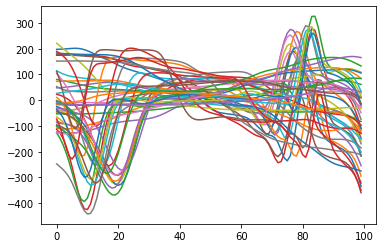

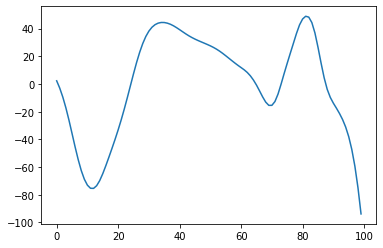

In [335]:
for i in range(np.shape(pwaves)[0]):
  plt.plot(pwaves[i])
plt.show()

plt.plot(np.mean(pwaves,axis=0))
plt.show()

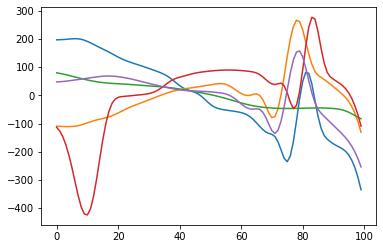

In [336]:
for i in range(5):
  plt.plot(pwaves[i])
plt.show()

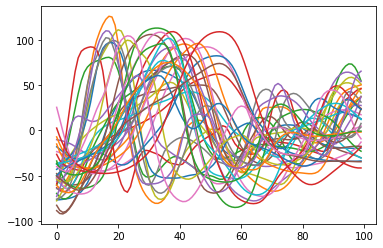

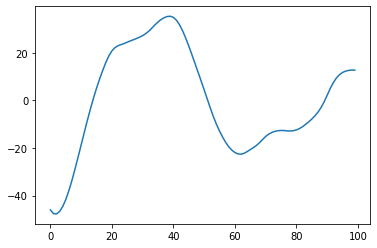

In [244]:
for i in range(np.shape(pwaves)[0]):
  plt.plot(pwaves[i])
plt.show()

plt.plot(np.mean(pwaves,axis=0))
plt.show()

In [256]:
def resampling(snipet,newsize):
  signals=snipet-np.mean(snipet)
  #signals = signal.detrend(snipet)
  n=signals.shape[0]
  x = np.linspace(0, n-1, num=n, endpoint=True)
  y = signals
  f1 = interp1d(x, y, kind='cubic')

  xnew = np.linspace(0, n-1, num=newsize, endpoint=True)
  return f1(xnew)


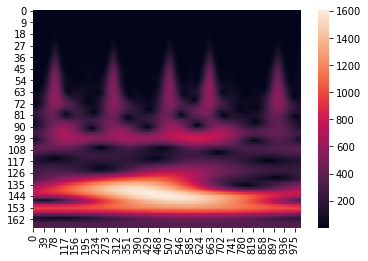

In [89]:
dt=1/300
dj= 1/24
s0=4*dt
J= 7/dj
mother=wavelet.Morlet(6)
#mother=wavelet.Paul(6)
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(patient[0:1000], dt, dj, s0, J,mother)
power = np.abs(wave)
sb.heatmap(power)

In [ ]:
# get lengths of signals for each sample

lengths = []
for patient in X_learn.iterrows():
  lengths.append(17979-patient[1].isna().sum())

In [ ]:
signals=[]

# for index in range(0,5117,1):

#load and clean Data
for index in tqdm(range(5117)):
  #print("index", index)
  ecg_signal = X_learn.iloc[index,800:lengths[index]]
  ecg_signal = nk.ecg_clean(ecg_signal, sampling_rate=300)


  out = ecg.ecg(signal=ecg_signal, sampling_rate=300, show=False)
  max=abs(np.mean(np.max(out['templates'],axis=1)))
  min=abs(np.mean(np.min(out['templates'],axis=1)))

  if max<min:
    print("invert")
    ecg_signal=-ecg_signal
    out = ecg.ecg(signal=ecg_signal, sampling_rate=300, show=False)
    max=min

  out = ecg.ecg(signal=ecg_signal, sampling_rate=300, show=False)

  signals.append(out)
# plt.plot(out['templates'].T)
# plt.show()
# plt.plot(np.median(out['templates'],axis=0))
# plt.show()
# plt.plot(np.mean(out['templates'],axis=0))
# plt.show()
# plt.plot(np.std(out['templates'].astype(np.float64),axis=0))
# plt.show()


In [ ]:
plt.hist(lengths,bins=50)

In [ ]:
min_l=30
for signal in signals:
  l,_=np.shape(signal['templates'])
  if min_l>l:
    min_l=l

signalVectors=[]
for signal in signals:
  meanheartbeat=np.mean(signal['templates'],axis=0)
  distance=[]
  for heartbeat in signal['templates']:
    distance.append(mean_squared_error(heartbeat,meanheartbeat))
  distance=np.array(distance)
  sel_id=distance.argsort()[-5:]
  sel_Signal=np.array(signal['templates'][sel_id])
  signalVectors.append(sel_Signal.flatten())¨

df=pd.DataFrame(data=signalVectors,index=X_learn.index)
df.to_csv('data/X_trainSignals.csv')

In [ ]:
X_learn=pd.read_csv('data/X_trainSignals.csv')
X_learn.set_index(["Y","idx"],inplace=True)
X_learn

In [ ]:
X_learnz=np.array(X_learn)
X_learnz=np.reshape(X_learnz,newshape=[5117,5,180])
X_learnzz=np.swapaxes(X_learnz,2,1)

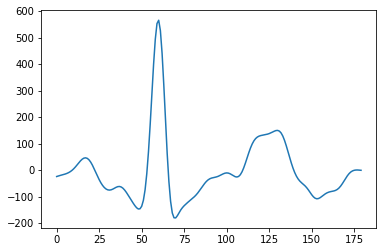

In [ ]:
plt.plot(X_learnz[2,0,:])

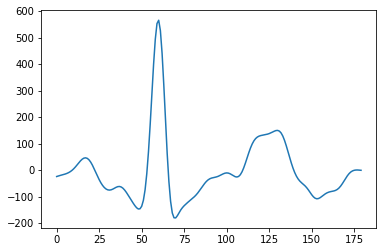

In [ ]:
plt.plot(X_learnzz[2,:,0])

In [ ]:
model=Sequential()
model.add(LSTM(128, input_shape=(180,5),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model=Sequential()
model.add(Bidirectional(LSTM(360, return_sequences=True), input_shape=(900, 1)))
model.add(Bidirectional(LSTM(360, return_sequences=True), input_shape=(900, 1)))
model.add(Dense(64, name='Dense1', activation='relu'))
model.add(Dense(16, name='Dense2', activation='relu'))
model.add(Dense(4, name='Output', activation='relu'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X_learn),X_learn.index.get_level_values("Y"),test_size=0.2)
y_trainOneHot=pp.OneHotEncoder(sparse=False).fit_transform(np.matrix(y_train).T)
y_testOneHot=pp.OneHotEncoder(sparse=False).fit_transform(np.matrix(y_test).T)
x_train_tmp= np.expand_dims(x_train, axis=-1)
x_test_tmp=np.expand_dims(x_test, axis=-1)



x_train_tmp=np.reshape(x_train,newshape=[x_train.shape[0],5,180])
x_train_tmp=np.swapaxes(x_train_tmp,2,1)
x_test_tmp=np.reshape(x_test,newshape=[x_test.shape[0],5,180])
x_test_tmp=np.swapaxes(x_test_tmp,2,1)
print(x_train.shape)
print(x_train_tmp.shape)
print(y_trainOneHot.shape)

(4093, 900)
(4093, 180, 5)
(4093, 4)


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 180, 720)          1054080   
_________________________________________________________________
lstm_23 (LSTM)               (None, 128)               434688    
_________________________________________________________________
Dense1 (Dense)               (None, 64)                8256      
_________________________________________________________________
Dense2 (Dense)               (None, 16)                1040      
_________________________________________________________________
Output (Dense)               (None, 4)                 68        
Total params: 1,498,132
Trainable params: 1,498,132
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(x_train_tmp, y_trainOneHot, epochs=5, validation_data=(x_test_tmp,y_testOneHot))

Epoch 1/5
128/128 [==============================] - 6s 46ms/step - loss: 1.1787 - accuracy: 0.7107 - val_loss: 1.7828 - val_accuracy: 0.5889
Epoch 2/5
128/128 [==============================] - 6s 45ms/step - loss: 1.1355 - accuracy: 0.7183 - val_loss: 2.2085 - val_accuracy: 0.5830
Epoch 3/5
128/128 [==============================] - 6s 46ms/step - loss: 1.1003 - accuracy: 0.7459 - val_loss: 2.1988 - val_accuracy: 0.5840
Epoch 4/5
128/128 [==============================] - 6s 46ms/step - loss: 1.1115 - accuracy: 0.7430 - val_loss: 2.0269 - val_accuracy: 0.5986
Epoch 5/5
128/128 [==============================] - 6s 45ms/step - loss: 1.2044 - accuracy: 0.7332 - val_loss: 1.9794 - val_accuracy: 0.5791


In [ ]:
y_hat=model.predict(x_train_tmp)

(array([3096.,    0.,  134.,  863.]),
 array([0. , 0.5, 1. , 1.5, 2. ]),
 <a list of 4 Patch objects>)

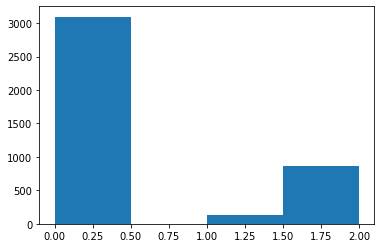

In [ ]:
plt.hist(np.argmax(y_hat,axis=1),bins=4)

(array([2422.,  362., 1175.,  134.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 Patch objects>)

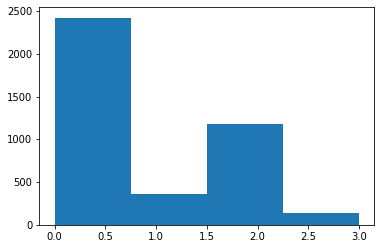

In [ ]:
plt.hist(y_train,bins=4)